# Indentifying Stress Factors in Rainbow Trouts - ML

In [7]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

# https://pmc.ncbi.nlm.nih.gov/articles/PMC11789298/

In [8]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


SEED = 32

In [9]:
import warnings
warnings.filterwarnings("ignore")

## Common Features

In [10]:
commonFeatures = []
with open("./primaryColumnList.txt", "r") as f:
  for line in f:
    commonFeatures.append(str(line.strip()))

In [21]:
observedFeatures = []
with open("./experimentalColumnList.txt", "r") as f:
  for line in f:
    observedFeatures.append(str(line.strip()))

In [23]:
len(observedFeatures)

234

## USDA Data

In [13]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
dataUSDA = pd.read_excel(dataPath)

dataUSDA.columns = columns
dataUSDA = dataUSDA.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
dataUSDA = dataUSDA.assign(tank = tankColums)

print(dataUSDA.shape)
dataUSDA.head()

(40, 125909)
CPU times: user 21.1 s, sys: 289 ms, total: 21.4 s
Wall time: 21.5 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


## UMD Data

In [14]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)

(72, 125910)
CPU times: user 38.7 s, sys: 507 ms, total: 39.2 s
Wall time: 39.2 s


## Primary Features

In [15]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

commonFeaturesUMD = list(set(umdDataFeatures) & set(commonFeatures))

print(f"{len(commonFeatures)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(commonFeaturesUMD)*100/len(commonFeatures):.2f}% of the training data feature set (USDA)")

54.86% of UMD data feature set
71.48% of the training data feature set (USDA)
CPU times: user 9.59 ms, sys: 618 µs, total: 10.2 ms
Wall time: 10.1 ms


## Merging UMD & USDA data

In [16]:
dataModelUSDA = dataUSDA.loc[:,commonFeaturesUMD+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')
dataModelUSDA.head()

GeneExp,LOC110535590_1,LOC110512351_2,pwwp2b_2,LOC110496418_3,phkb_1,LOC110531981_1,shroom1_3,cby1_1,LOC110515557_1,LOC110536162_2,...,LOC110506482_2,LOC110525396_1,LOC110528871_2,LOC110501806_2,LOC110526974_5,LOC118936579_1,shox_1,LOC110537627_1,tank,src
0,1.922174,0.097886,3.243780,0.545060,5.811768,4.744304,0.112643,0.815829,0.061839,4.781250,...,0.588275,0.259505,0.283697,0.255216,0.370460,2.561280,4.035005,0.082816,0,usda
1,1.936807,0.030971,3.028521,0.615252,5.695007,4.754125,0.141411,0.844783,0.082987,4.849081,...,0.590605,0.262744,0.269285,0.248393,0.432224,2.562582,3.845985,0.080677,0,usda
2,1.776053,0.000000,3.267829,0.431083,5.142105,5.384767,0.106331,1.100665,0.082012,3.350629,...,0.643186,0.527956,0.284634,0.253054,0.467830,3.279695,4.638710,0.074707,0,usda
3,1.600539,0.053923,3.185701,0.401701,5.423831,5.342155,0.087073,0.628168,0.075767,4.040982,...,0.635669,0.364536,0.187538,0.238216,0.440042,3.279504,5.306910,0.097245,0,usda
4,1.522633,0.074945,3.206237,0.236857,4.727164,4.389959,0.045904,0.000000,0.061224,3.941717,...,0.753563,0.208621,0.130325,0.193202,0.412161,2.809020,2.510100,0.085099,0,usda


In [17]:
dataModelUMD = dataUMD.loc[:, commonFeaturesUMD+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')
dataModelUMD.head()

idx,LOC110535590_1,LOC110512351_2,pwwp2b_2,LOC110496418_3,phkb_1,LOC110531981_1,shroom1_3,cby1_1,LOC110515557_1,LOC110536162_2,...,LOC110506482_2,LOC110525396_1,LOC110528871_2,LOC110501806_2,LOC110526974_5,LOC118936579_1,shox_1,LOC110537627_1,tank,src
0,0.358499,0.062456,2.646497,0.338377,1.897728,3.352561,0.50774,5.785096,0.110207,0.265827,...,0.563024,0.480175,0.14481,0.08532,0.465357,2.915108,8.399432,0.133492,0,umd
1,0.53486,0.165979,2.569794,0.374685,3.338979,4.418277,1.127522,4.024281,0.112089,0.2523,...,0.997498,1.158734,0.256558,0.168225,0.490753,2.034555,13.085111,0.251287,0,umd
2,0.579632,0.071061,3.705968,0.481243,2.79948,3.827819,0.633085,6.420572,0.162542,0.259242,...,0.5174,0.621683,0.08238,0.144045,0.403405,3.417222,7.323068,0.175615,0,umd
3,0.89202,0.192044,4.186167,0.498554,3.219442,3.409085,1.240427,4.201539,0.172573,0.379498,...,0.915547,0.840059,0.139147,0.143867,0.408831,3.497137,10.489142,0.214855,0,umd
4,0.606148,0.136801,4.198925,0.329406,2.876232,3.255087,1.020719,5.908121,0.181788,0,...,1.043492,0.834146,0.13216,0.168794,0.447627,2.579837,8.50569,0.197975,0,umd


In [18]:
dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(88, 49381)


,LOC110535590_1,LOC110512351_2,pwwp2b_2,LOC110496418_3,phkb_1,LOC110531981_1,shroom1_3,cby1_1,LOC110515557_1,LOC110536162_2,...,LOC110525396_1,LOC110528871_2,LOC110501806_2,LOC110526974_5,LOC118936579_1,shox_1,LOC110537627_1,tank,src,strat
69,1.610333,0.236031,2.372147,0.195368,2.580192,2.400593,0.950649,1.855423,0.1414,0.849124,...,0.281583,0.228024,0.167285,0.390811,2.309035,4.195865,0.044668,1,umd,1_umd
26,0.329116,0.159425,2.901372,0.215935,2.644783,3.343019,0.627314,4.227772,0.448017,0,...,0.676244,0.061607,0.113577,0.333106,2.254875,7.119398,0.191673,0,umd,0_umd
9,0.353097,0.267151,13.442689,0.180922,1.105641,3.484437,0.676832,6.869461,0.331726,0.954311,...,0.602007,0.270993,0.36789,0.663509,3.070048,7.502172,0.544236,0,umd,0_umd
64,2.078856,0.08879,4.304999,0.180393,2.223422,1.764299,0.449902,4.364425,0.70213,0.04049,...,0.329547,0.0772,0.147704,0.420043,3.045373,7.800488,0.139368,1,umd,1_umd
1,1.936807,0.030971,3.028521,0.615252,5.695007,4.754125,0.141411,0.844783,0.082987,4.849081,...,0.262744,0.269285,0.248393,0.432224,2.562582,3.845985,0.080677,0,usda,0_usda


In [25]:
dataModel['strat'].value_counts()

strat
1_umd     36
0_umd     36
0_usda    10
1_usda     6
Name: count, dtype: int64

# Models

In [26]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(4, 2))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

In [27]:
%%time
# xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3]
# ydata = np.array(ydata.astype(int))

xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3:-1]
ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 377 ms, sys: 17.9 ms, total: 395 ms
Wall time: 396 ms


## Logistic Regression

In [28]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 33.1 s, sys: 11.8 s, total: 44.9 s
Wall time: 5.78 s


LogisticRegression(random_state=32)

In [29]:
%%time
ypred = logRes_clf.predict(xstest)

CPU times: user 72.8 ms, sys: 172 ms, total: 244 ms
Wall time: 33 ms


              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.86      0.92      0.89        13

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



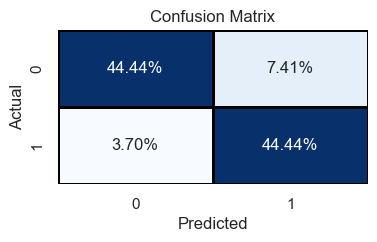

In [30]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [31]:
importances = logRes_clf.coef_[0]

49376


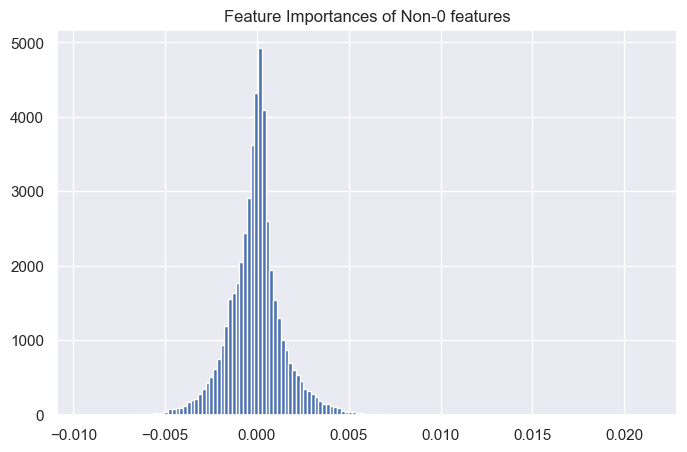

In [32]:
print(len(importances[importances!=0]))

plt.figure(figsize=(8,5), dpi = 100)
plt.hist(importances[importances!=0], bins = 150)
# plt.hist(importances, bins = 150)
plt.title("Feature Importances of Non-0 features")
plt.show()

## Decision Trees

In [38]:
%%time
dt_clf = DecisionTreeClassifier()

dt_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 181 ms, sys: 4.74 ms, total: 186 ms
Wall time: 184 ms


DecisionTreeClassifier()

In [39]:
%%time
ypred = dt_clf.predict(xstest)

CPU times: user 2.83 ms, sys: 2.59 ms, total: 5.42 ms
Wall time: 3.15 ms


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.85      0.85      0.85        13

    accuracy                           0.85        27
   macro avg       0.85      0.85      0.85        27
weighted avg       0.85      0.85      0.85        27



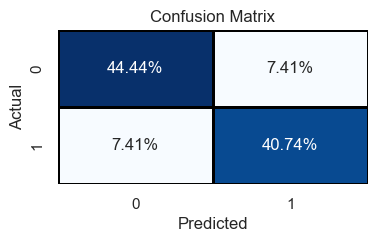

In [40]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [41]:
importance = dt_clf.feature_importances_

In [42]:
for i,j in zip(xdata.columns, importance):
    if j != 0:
        print(i, j)

LOC118936524_1 1.0


## Recursive Feature Elimination 

In [116]:
%%time
# logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf = LogisticRegression(random_state=SEED)
selector = RFE(logRes_clf, n_features_to_select=100, step=0.05, verbose = 0)

selector.fit(xstrain, ytrain.iloc[:,0].astype(int))

Fitting estimator with 49378 features.
Fitting estimator with 46910 features.
Fitting estimator with 44442 features.
Fitting estimator with 41974 features.
Fitting estimator with 39506 features.
Fitting estimator with 37038 features.
Fitting estimator with 34570 features.
Fitting estimator with 32102 features.
Fitting estimator with 29634 features.
Fitting estimator with 27166 features.
Fitting estimator with 24698 features.
Fitting estimator with 22230 features.
Fitting estimator with 19762 features.
Fitting estimator with 17294 features.
Fitting estimator with 14826 features.
Fitting estimator with 12358 features.
Fitting estimator with 9890 features.
Fitting estimator with 7422 features.
Fitting estimator with 4954 features.
Fitting estimator with 2486 features.
CPU times: user 8min 8s, sys: 2min 25s, total: 10min 34s
Wall time: 1min 22s


RFE(estimator=LogisticRegression(random_state=32), n_features_to_select=100,
    step=0.05, verbose=1)

---

# Observed Features

In [48]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

observedFeaturesUMD = list(set(umdDataFeatures) & set(observedFeatures))

print(f"{len(observedFeaturesUMD)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(observedFeaturesUMD)*100/len(observedFeatures):.2f}% of the training data feature set (USDA)")

0.19% of UMD data feature set
100.00% of the training data feature set (USDA)
CPU times: user 19.8 ms, sys: 2.58 ms, total: 22.4 ms
Wall time: 21.5 ms


In [49]:
EXP_COLUMNS = observedFeaturesUMD

dataModelUSDA = dataUSDA.loc[:,EXP_COLUMNS+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')

dataModelUMD = dataUMD.loc[:, EXP_COLUMNS+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')

dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(88, 237)


,LOC110535590_1,LOC110492627_2,LOC110533369_1,LOC100136615_2,LOC110485781_2,gmip_2,LOC110533369_3,LOC110493270_1,LOC110535646_4,glsb_5,...,LOC110485460_1,LOC110494417_2,LOC110488389_2,LOC110492485_1,sb:cb288_3,LOC110522505_2,LOC110522505_1,tank,src,strat
12,0.920775,3.269208,0.594895,16.814114,5.180846,3.565245,1.027547,1.14806,0.788521,3.718226,...,0.223783,3.21142,4.958677,2.00549,22.029855,4.352633,4.451556,0,umd,0_umd
68,0,6.876938,7.048067,10.434624,5.605932,13.514967,6.443947,7.166622,5.844188,13.18562,...,7.08271,8.838371,0.256441,14.256116,22.014534,11.664222,9.945284,1,umd,1_umd
25,0.843562,3.172177,1.10445,36.545747,5.529785,4.358206,0.956292,1.16051,1.514932,5.251278,...,0.780259,6.502721,7.512626,8.112519,18.232086,6.898294,6.504106,0,umd,0_umd
18,0.711789,1.981184,1.170586,24.491815,4.651782,4.125722,1.109777,1.537678,1.570585,4.700167,...,1.289571,2.865213,0,5.591929,9.336609,3.336917,3.781839,0,umd,0_umd
38,3.580058,5.182438,15.823078,86.040828,1.330386,10.021948,16.257962,4.734293,3.028679,8.861697,...,19.19466,11.515687,18.43184,0.517926,2.888413,38.916912,41.568484,1,umd,1_umd


In [51]:
%%time
EXP_COLS = observedFeaturesUMD

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 14.9 ms, sys: 3.37 ms, total: 18.3 ms
Wall time: 15.9 ms


In [52]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 188 ms, sys: 57.3 ms, total: 245 ms
Wall time: 47.2 ms


LogisticRegression(random_state=32)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.92      0.96        13

    accuracy                           0.96        27
   macro avg       0.97      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



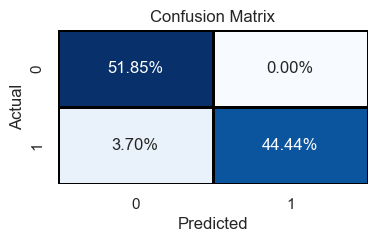

CPU times: user 106 ms, sys: 6.67 ms, total: 113 ms
Wall time: 69 ms


In [53]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

# Experimental Section
**CAUTION:** Section is extremely experimental.

In [43]:
%%time
EXP_COLS=['LOC110533950_2', 'LOC110522187_1']

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

KeyError: "['hspa1b_2', 'LOC110532154_1', 'LOC118938279_2', 'vwa1_1', 'LOC110503972_1', 'tgm1l1_1', 'LOC110520238_2', 'tgm1l1_2', 'LOC100136252_2'] not in index"

In [141]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 6.04 ms, sys: 1.81 ms, total: 7.85 ms
Wall time: 6.21 ms


LogisticRegression(random_state=32)

In [142]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

CPU times: user 591 µs, sys: 23 µs, total: 614 µs
Wall time: 611 µs


              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.87      1.00      0.93        13

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.94      0.93      0.93        27



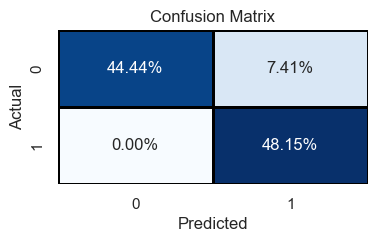

In [143]:
_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

## Isolated Datsets

In [162]:
%%time
xtrainEXPv2, ytrainEXPv2 = dataModelUSDA.loc[:,EXP_COLS], dataModelUSDA.iloc[:,-2]

xtestEXPv2, ytestEXPv2 = dataModelUMD.loc[:,EXP_COLS], dataModelUMD.iloc[:,-2]

xtrainEXPv2, ytrainEXPv2 = shuffle(xtrainEXPv2, ytrainEXPv2, random_state=SEED)
xtestEXPv2, ytestEXPv2 = shuffle(xtestEXPv2, ytestEXPv2 , random_state=SEED)

sca = StandardScaler()

xtrainEXPv2_sca = sca.fit_transform(xtrainEXPv2)
xtestEXPv2_sca = sca.transform(xtestEXPv2)

CPU times: user 8.11 ms, sys: 460 µs, total: 8.57 ms
Wall time: 8.25 ms


In [165]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xtrainEXPv2_sca, ytrainEXPv2.astype(int))

CPU times: user 5.12 ms, sys: 1.99 ms, total: 7.12 ms
Wall time: 6.4 ms


LogisticRegression(random_state=32)

In [167]:
%%time
ypredEXPv2 = logRes_clf.predict(xtestEXPv2)

CPU times: user 1.77 ms, sys: 31 µs, total: 1.8 ms
Wall time: 1.86 ms


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        36
           1       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



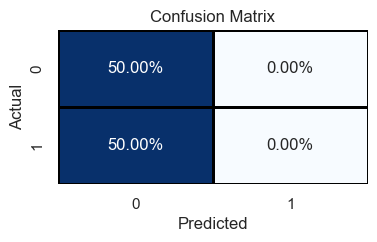

In [168]:
_ = resultAnalysisFnx(ytestEXPv2.astype(int), ypredEXPv2, target_names=None)

## Statstical Variation

In [174]:
dataModelExp_temp = dataModel[EXP_COLS+['tank', 'src']]

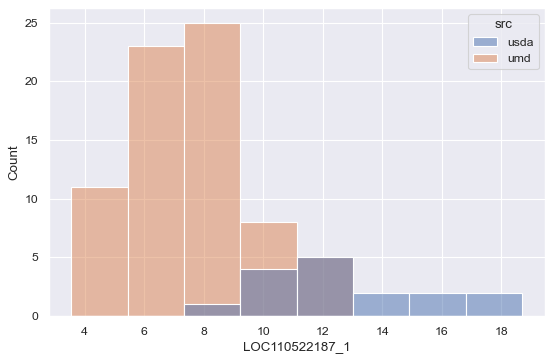

In [192]:
transcript = 'LOC110522187_1'
# transcript = 'LOC110533950_2'

plt.figure(figsize=(8,5), dpi = 80)
sns.histplot(data = dataModelExp_temp, x=transcript, hue='src', binwidth=2)
plt.show()

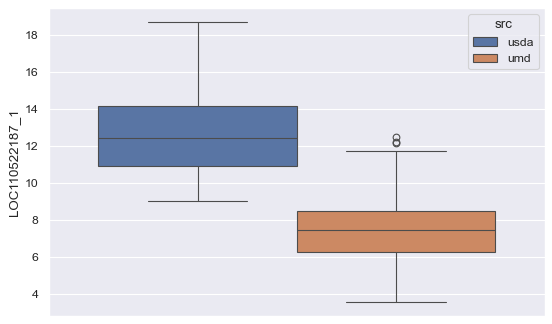

In [193]:
plt.figure(figsize=(8,5), dpi = 80)
sns.boxplot(data = dataModelExp_temp, y=transcript, hue='src', orient='h')
plt.show()